__1. Попробуйте изменить параметры нейронной сети работающей с датасетом imdb либо нейронной сети работающей airline-passengers(она прилагается вместе с датасетом к уроку в виде отдельного скрипта) так, чтобы улучшить ее точность. Приложите анализ.__

Train Score: 22.85 RMSE
Test Score: 56.98 RMSE


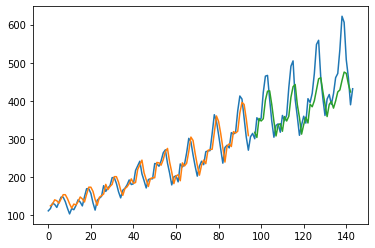

In [1]:
import numpy
import matplotlib.pyplot as plt
from pandas import read_csv
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return numpy.array(dataX), numpy.array(dataY)

numpy.random.seed(7)

dataframe = read_csv('../data/airline-passengers.csv', usecols=[1], engine='python')
dataset = dataframe.values
dataset = dataset.astype('float32')
scaler = MinMaxScaler(feature_range=(-1, 1))
dataset = scaler.fit_transform(dataset)

train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)
# reshape input to be [samples, time steps, features]
trainX = numpy.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = numpy.reshape(testX, (testX.shape[0], testX.shape[1], 1))

batch_size = 1
model = Sequential()
model.add(LSTM(units=5, 
               batch_input_shape=(batch_size, look_back, 1),
               stateful=False,
               activation='sigmoid',
               recurrent_activation='sigmoid',
               dropout=0.0,
               recurrent_dropout=0.1))
model.add(Dense(1))
model.compile(loss='mse', optimizer='RMSprop')
for i in range(200):
    model.fit(trainX, trainY, epochs=1, batch_size=batch_size, verbose=0, shuffle=False)
    model.reset_states()

trainPredict = model.predict(trainX, batch_size=batch_size)
model.reset_states()
testPredict = model.predict(testX, batch_size=batch_size)

trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

trainPredictPlot = numpy.empty_like(dataset)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

testPredictPlot = numpy.empty_like(dataset)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict

plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

Лучшая точность получается при изменении следующих параметров:

    для LSTM:
        units=5
        stateful=False
        activation='sigmoid'
        recurrent_dropout=0.1
    optimizer='RMSprop'
    look_back = 1
    итерация до 200.

__2. Попробуйте изменить параметры нейронной сети генерирующий текст таким образом, чтобы добиться генерации как можно более осмысленного текста. Пришлите лучший получившейся у вас текст и опишите, что вы предприняли, чтобы его получить. Можно использовать текст другого прозведения.__

In [2]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
import tensorflow.keras.utils as ku
from tensorflow.keras.callbacks import EarlyStopping

In [3]:
# Создаем объект для токенизапции
tokenizer = Tokenizer(num_words=1000)
with open("../data/alice_in_wonderland.txt", encoding='utf-8') as file:
    alice = file.read().lower().split("\n")

In [4]:
tokenizer.fit_on_texts(alice)
total_words = len(tokenizer.word_index) + 1

# create input sequences using list of tokens
input_sequences = []
for line in alice:
    token_list = tokenizer.texts_to_sequences([line])[0]
    for i in range(1, len(token_list)):
        n_gram_sequence = token_list[:i+1]
        input_sequences.append(n_gram_sequence)

# pad sequences 
max_sequence_len = max([len(x) for x in input_sequences])
input_sequences = numpy.array(pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre'))

# create predictors and label
predictors, label = input_sequences[:,:-1],input_sequences[:,-1]

label = ku.to_categorical(label, num_classes=total_words)

In [5]:
callback = EarlyStopping(monitor='val_loss', patience=10)
model = Sequential()
model.add(Embedding(total_words, 64, input_length=max_sequence_len-1))
model.add(Bidirectional(LSTM(50, return_sequences=True)))
model.add(Dropout(0.1))
model.add(LSTM(20))
model.add(Dense(total_words, activation='relu', kernel_regularizer=regularizers.l2(0.02)))
model.add(Dense(total_words, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 17, 64)            217536    
_________________________________________________________________
bidirectional (Bidirectional (None, 17, 100)           46000     
_________________________________________________________________
dropout (Dropout)            (None, 17, 100)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 20)                9680      
_________________________________________________________________
dense_1 (Dense)              (None, 3399)              71379     
_________________________________________________________________
dense_2 (Dense)              (None, 3399)              11556600  
Total params: 11,901,195
Trainable params: 11,901,195
Non-trainable params: 0
__________________________________________

In [6]:
history = model.fit(predictors, label, epochs=50, validation_split=0.2, callbacks=[callback], verbose=0)

In [7]:
seed_text = "She seemed that day to be more than ever kind and affectionate to everyone"
next_words = 20
  
for _ in range(next_words):
    token_list = tokenizer.texts_to_sequences([seed_text])[0]
    token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
    predicted = numpy.argmax(model.predict(token_list))
    output_word = ""
    for word, index in tokenizer.word_index.items():
        if index == predicted:
            output_word = word
            break
    seed_text += " " + output_word
print(seed_text)

She seemed that day to be more than ever kind and affectionate to everyone the ’ said the mock turtle said and the little ’ said the mock turtle said and the little ’


__3. * Попробуйте на numpy реализовать нейронную сеть архитектуры LSTM__

In [8]:
import numpy as np
from numpy.random import randn

class RNN:
    # A many-to-one Vanilla Recurrent Neural Network.

    def __init__(self, input_size, output_size, hidden_size=64):
        # Weights
        self.Whh = randn(hidden_size, hidden_size) / 1000
        self.Wxh = randn(hidden_size, input_size) / 1000
        self.Why = randn(output_size, hidden_size) / 1000

        # Biases
        self.bh = np.zeros((hidden_size, 1))
        self.by = np.zeros((output_size, 1))

    def forward(self, inputs):
        '''
        Perform a forward pass of the RNN using the given inputs.
        Returns the final output and hidden state.
        - inputs is an array of one hot vectors with shape (input_size, 1).
        '''
        h = np.zeros((self.Whh.shape[0], 1))

        self.last_inputs = inputs
        self.last_hs = { 0: h }

        # Perform each step of the RNN
        for i, x in enumerate(inputs):
            h = np.tanh(self.Wxh @ x + self.Whh @ h + self.bh)
            self.last_hs[i + 1] = h

        # Compute the output
        y = self.Why @ h + self.by

        return y, h

    def backprop(self, d_y, learn_rate=2e-2):
        '''
        Perform a backward pass of the RNN.
        - d_y (dL/dy) has shape (output_size, 1).
        - learn_rate is a float.
        '''
        n = len(self.last_inputs)

        # Calculate dL/dWhy and dL/dby.
        d_Why = d_y @ self.last_hs[n].T
        d_by = d_y

        # Initialize dL/dWhh, dL/dWxh, and dL/dbh to zero.
        d_Whh = np.zeros(self.Whh.shape)
        d_Wxh = np.zeros(self.Wxh.shape)
        d_bh = np.zeros(self.bh.shape)

        # Calculate dL/dh for the last h.
        # dL/dh = dL/dy * dy/dh
        d_h = self.Why.T @ d_y

        # Backpropagate through time.
        for t in reversed(range(n)):
            # An intermediate value: dL/dh * (1 - h^2)
            temp = ((1 - self.last_hs[t + 1] ** 2) * d_h)

            # dL/db = dL/dh * (1 - h^2)
            d_bh += temp

            # dL/dWhh = dL/dh * (1 - h^2) * h_{t-1}
            d_Whh += temp @ self.last_hs[t].T

            # dL/dWxh = dL/dh * (1 - h^2) * x
            d_Wxh += temp @ self.last_inputs[t].T

            # Next dL/dh = dL/dh * (1 - h^2) * Whh
            d_h = self.Whh @ temp

        # Clip to prevent exploding gradients.
        for d in [d_Wxh, d_Whh, d_Why, d_bh, d_by]:
            np.clip(d, -1, 1, out=d)

        # Update weights and biases using gradient descent.
        self.Whh -= learn_rate * d_Whh
        self.Wxh -= learn_rate * d_Wxh
        self.Why -= learn_rate * d_Why
        self.bh -= learn_rate * d_bh
        self.by -= learn_rate * d_by

__4. *Предложите свои варианты решения проблемы исчезающего градиента в RNN__

Эффективными способами решения проблемы исчезающего градиента являются: использование остаточных нейронных сетей, ипользование функции активации ReLU и ей подобных, использование бОльших вычислительных мощностей, а также использование сетей с долгой кратковременной памятью (LSTM)